In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Mounted at /content/drive
/content


In [2]:
!ls
%cd drive/MyDrive/DA/clustering
!pwd

drive  sample_data
/content/drive/.shortcut-targets-by-id/16BzENDslJoHpb3XlZqeoy64RYYEZ8ltp/clustering
/content/drive/.shortcut-targets-by-id/16BzENDslJoHpb3XlZqeoy64RYYEZ8ltp/clustering


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import pi
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
import collections

##Loading Pre-processed Data (Columns with very high correlation are removed)

In [8]:
df_data_pro_names = pd.read_csv('dropped_football_data_with_names.csv', na_values=np.NaN)
print(df_data_pro_names.shape)
display(df_data_pro_names.head())
display(df_data_pro_names.info())
display(df_data_pro_names.describe())

(18147, 50)


,Name,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Jersey Number,Height,Weight,LS,LWB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,GKDiving,Release Clause,Attack Work Rate,Defense Work Rate
0,L. Messi,31,94,94,110.5,565.0,2202,0,5.0,4.0,4.0,1,1,10.0,5.7,159,88.0,64.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,6.0,226.5,1,1
1,Cristiano Ronaldo,33,94,94,77.0,405.0,2228,1,5.0,4.0,5.0,1,1,7.0,6.2,183,91.0,65.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,7.0,127.1,2,0
2,Neymar Jr,26,92,93,118.5,290.0,2143,1,5.0,5.0,5.0,1,1,10.0,5.9,150,84.0,65.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,9.0,228.1,2,1
3,De Gea,27,91,93,72.0,260.0,1471,1,4.0,3.0,1.0,0,1,1.0,6.4,168,0.0,0.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,90.0,138.6,1,1
4,K. De Bruyne,27,91,92,102.0,355.0,2281,1,4.0,5.0,4.0,1,1,7.0,5.1,154,82.0,77.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,15.0,196.4,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18147 entries, 0 to 18146
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      18147 non-null  object 
 1   Age                       18147 non-null  int64  
 2   Overall                   18147 non-null  int64  
 3   Potential                 18147 non-null  int64  
 4   Value                     18147 non-null  float64
 5   Wage                      18147 non-null  float64
 6   Special                   18147 non-null  int64  
 7   Preferred Foot            18147 non-null  int64  
 8   International Reputation  18147 non-null  float64
 9   Weak Foot                 18147 non-null  float64
 10  Skill Moves               18147 non-null  float64
 11  Body Type                 18147 non-null  int64  
 12  Real Face                 18147 non-null  int64  
 13  Jersey Number             18147 non-null  float64
 14  Height

None

,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Jersey Number,Height,Weight,LS,LWB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,GKDiving,Release Clause,Attack Work Rate,Defense Work Rate
count,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000
mean,25.121122,66.253926,71.324076,264.965851,9.759024,1598.002645,0.768061,1.113297,2.947154,2.361492,0.709484,0.091145,19.546096,5.796225,165.982972,51.363917,51.095443,49.738414,45.550229,52.300766,58.695432,42.912217,55.375158,47.176283,42.866038,52.721386,58.374828,64.612829,64.726236,63.501295,61.839147,63.964292,55.465201,65.091034,63.221579,65.318620,47.113187,55.876068,46.702761,49.962198,53.407781,48.546371,58.651127,47.286053,47.701879,16.616906,209.288246,1.218218,1.086185
std,4.669796,6.913320,6.132286,289.865229,22.030250,272.882706,0.422082,0.394150,0.660498,0.756274,0.576000,0.287822,15.947765,0.450096,15.593388,20.127113,19.980009,18.364255,19.527445,17.381753,14.696075,17.695900,18.912224,18.396009,17.480034,15.325211,16.685643,14.930320,14.651776,14.768956,9.011056,14.136073,17.235534,11.822327,15.896381,12.552479,19.263142,17.366534,20.697462,19.530469,14.146594,15.703113,11.437138,19.900450,21.663630,17.698612,293.407285,0.521755,0.502896
min,16.000000,46.000000,48.000000,0.000000,0.000000,731.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,5.100000,110.000000,0.000000,0.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,3.000000,9.000000,5.000000,12.000000,12.000000,14.000000,21.000000,16.000000,2.000000,15.000000,12.000000,17.000000,3.000000,11.000000,3.000000,2.000000,10.000000,5.000000,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,21.000000,62.000000,67.000000,4.400000,1.000000,1457.000000,1.000000,1.000000,3.000000,2.000000,0.000000,0.000000,8.000000,5.100000,154.000000,48.000000,48.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,31.000000,43.000000,54.000000,57.000000,57.000000,55.000000,56.000000,56.000000,45.000000,58.000000,56.000000,58.000000,33.000000,44.000000,26.000000,38.000000,44.000000,39.000000,51.000000,30.000000,27.000000,8.000000,1.800000,1.000000,1.000000
50%,25.000000,66.000000,71.000000,160.000000,3.000000,1635.000000,1.000000,1.000000,3.000000,2.000000,1.000000,0.000000,17.000000,5.900000,165.000000,57.000000,56.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,41.000000,56.000000,63.000000,67.000000,67.000000,66.000000,62.000000,66.000000,59.000000,66.000000,66.000000,67.000000,51.000000,59.000000,52.000000,55.000000,55.000000,49.000000,60.000000,53.000000,55.000000,11.000000,12.600000,1.000000,1.000000
75%,28.000000,71.000000,75.000000,475.000000,9.000000,1787.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,26.000000,6.100000,176.000000,64.000000,63.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,57.000000,64.000000,69.000000,75.000000,75.000000,74.000000,68.000000,74.000000,68.000000,73.000000,74.000000,74.000000,62.000000,69.000000,64.000000,64.000000,64.000000,60.000000,67.000000,64.000000,66

In [9]:
df_data_pro = df_data_pro_names.drop(['Name'],axis=1)

##Standardizing Data

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_data_pro.values)
X_df = pd.DataFrame(X_scaled)

##Visualizing Dendogram for Data

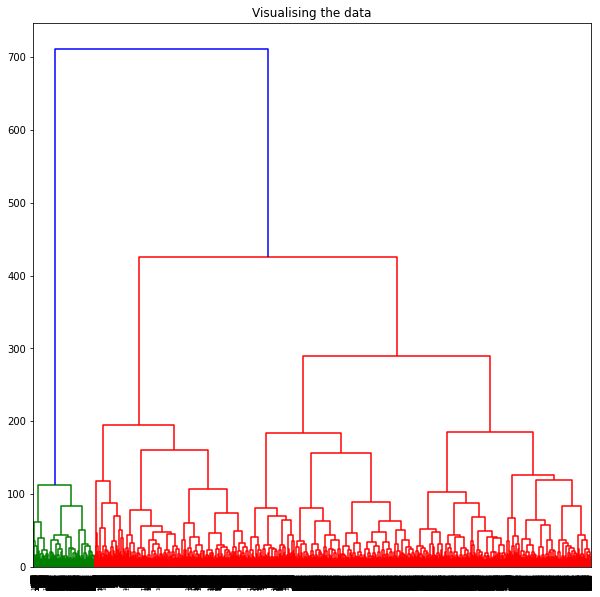

In [12]:
plt.figure(figsize =(10, 10))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_scaled, method ='ward')))

##Functions for Analysing Clusters  
1) Quality of clusters : Silhoutte score  (cluster centroids calculated using cluster means)  
2) Detecting outliers : Datapoints having negative silhoutte score  
3) Intracluster distance : Average Complete Diameter  
4) Intercluster distance : Average Linkage Distance  
5) Similar attributes per cluster : Top K attributes having the minimum average difference  
6) Attributes different in outliers : Top K attributes having the maximum average difference  
7) Most discriminative feature between pair of clusters : Max distances between attribute-wise mean (centroids) of the clusters  


In [17]:
def euclid_distance(X1, X2):
    all_dists = -2 * np.dot(X1, X2.T) + np.sum(X2**2, axis=1) + np.sum(X1**2, axis=1)[:, np.newaxis]
    return all_dists

def euclid_vectors(X1, X2):
    all_dists = -2 * np.dot(X1, X2.T) + X2**2 + (X1**2)[:, np.newaxis]
    return all_dists

def silhouette_score(labels,data):
    centroids = []
    clusters = {}
    unq_labels = np.unique(labels)
    for cl in unq_labels:
        clusters[cl] = data[labels==cl,:]
        centroids.append(np.mean(clusters[cl],axis=0))
    centroids = np.array(centroids)
    center_dists = euclid_distance(centroids,centroids)
    tot_S = []
    outliers = []
    for c in range(len(unq_labels)):
        cur_cdists = euclid_distance(clusters[c],clusters[c])
        a = np.sum(cur_cdists,axis=1) / (len(clusters[c])-1)
        nearest_center = np.argmin(np.concatenate((center_dists[c,:c],center_dists[c,c+1:])))
        nearest_cdists = euclid_distance(clusters[c],clusters[nearest_center])
        b = np.sum(nearest_cdists,axis=1) / (len(clusters[nearest_center]))
        s = None
        if len(clusters[nearest_center]) > 1:
            s = (b - a) / np.max(np.stack((a,b),axis=0),axis=0)
        else:
            s = np.array([0])
        outliers.extend(clusters[c][s<0])
        tot_S.append(s.mean())
    return np.mean(tot_S), np.array(outliers)

def avg_diameter_dist(labels,data):
    diam = 0
    unq_labels = np.unique(labels)
    for cl in unq_labels:
        if cl==-1:
            continue
        cluster = data[labels==cl,:]
        cur_cdists = euclid_distance(cluster,cluster)
        # print("Points in cluster",cl," : ",cur_cdists.shape[0])
        ad = np.mean(cur_cdists)
        diam += ad
    print("\nAverage Complete Diameter (Intracluster) :",diam//len(unq_labels))

def avg_linkage_dist(labels,data):
    linkage = 0
    unq_labels = np.unique(labels)
    # print(unq_labels)
    for i in range(len(unq_labels)):
        if unq_labels[i]==-1:
            continue
        c1 = data[labels==unq_labels[i],:]
        j = i+1
        while j < len(unq_labels):
            if unq_labels[j]==-1:
                j+=1
                continue
            c2 = data[labels==unq_labels[j],:]
            cur_cdists = euclid_distance(c1,c2)
            ad = np.mean(cur_cdists)
            # print(i,j,ad)
            linkage += ad
            j += 1
        i += 1
    print("\nAverage Linkage Distance (Intercluster) :",linkage//len(unq_labels))

def cluster_diff_by(labels,data,cols,k=1):
    clst_means = []
    all_dists = []
    unq_labels = np.unique(labels)
    for cl in unq_labels:
        if cl==-1:
            continue
        clst_means.append(np.mean(data[labels==cl],axis=0))
    clst_means = np.array(clst_means)
    for i in range(len(clst_means)):
        cur_dist = (clst_means - clst_means[i])**2
        for j in range(i+1,len(cur_dist)):
            indx = np.argmax(cur_dist[j])
            print("\nMost discriminative feature in clusters",i,"&",j,": ",cols[indx])


def similar_attributes(labels,data,cols,k=5):
    std = StandardScaler()
    # data_std = std.fit_transform(data)  ## bring all features to same scale
    for cl in np.unique(labels):
        if cl==-1:
            continue
        mean_dists = []
        cluster = data[labels==cl,:]
        for col in range(len(cols)):
            cur_cdists = euclid_vectors(cluster[:,col],cluster[:,col])
            # print(cur_cdists.shape)
            ad = abs(np.mean(cur_cdists))
            mean_dists.append(ad)
        mean_dists = np.asarray(mean_dists)
        indx = np.argsort(mean_dists)[:k]
        print("\nTop K similar features in cluster ",cl," : ",list(cols[indx]))
        print("Name of cluster",cl," : ",tuple(cols[indx])[:3])
        

def diff_attrs_outliers(labels,data,cols,k=5):
    # std = StandardScaler()
    # data = std.fit_transform(data)  ## bring all features to same scale
    outliers = data[labels==-1,:]
    mean_dists = []
    for col in range(len(cols)):
        cur_cdists = euclid_vectors(outliers[:,col],outliers[:,col])
        # print(cur_cdists.shape)
        ad = abs(np.mean(cur_cdists))
        mean_dists.append(ad)
    mean_dists = np.asarray(mean_dists)
    indx = np.argsort(mean_dists)[:k]
    print("\nTop K different features in outliers : ",list(cols[indx]))


##Agglomerative Clustering for 3 Clusters

In [21]:
agg1 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels_agg1 = agg1.fit_predict(X_scaled)
counts = collections.Counter(labels_agg1)
print(counts)

score, outliers = silhouette_score(labels_agg1,X_scaled)
print("\nSilhouette Score:",score,"\nNumber of outliers:",len(outliers))
avg_diameter_dist(labels_agg1,X_scaled)
avg_linkage_dist(labels_agg1,X_scaled)
similar_attributes(labels_agg1,X_scaled,df_data_pro.columns)
cluster_diff_by(labels_agg1,X_scaled,df_data_pro.columns)
diff_attrs_outliers(labels_agg1,X_scaled,df_data_pro.columns)

Counter({0: 11110, 2: 5012, 1: 2025})

Silhouette Score: 0.5376234497489448 
Number of outliers: 368

Average Complete Diameter (Intracluster) : 56.0

Average Linkage Distance (Intercluster) : 174.0

Top K similar features in cluster  0  :  ['GKDiving', 'LS', 'Wage', 'International Reputation', 'LWB']
Name of cluster 0  :  ('GKDiving', 'LS', 'Wage')

Top K similar features in cluster  1  :  ['Defense Work Rate', 'Attack Work Rate', 'Wage', 'Preferred Foot', 'Value']
Name of cluster 1  :  ('Defense Work Rate', 'Attack Work Rate', 'Wage')

Top K similar features in cluster  2  :  ['GKDiving', 'Jersey Number', 'Release Clause', 'LWB', 'LS']
Name of cluster 2  :  ('GKDiving', 'Jersey Number', 'Release Clause')

Most discriminative feature in clusters 0 & 1 :  GKDiving

Most discriminative feature in clusters 0 & 2 :  Overall

Most discriminative feature in clusters 1 & 2 :  LS

Top K different features in outliers :  ['Age', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility']


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


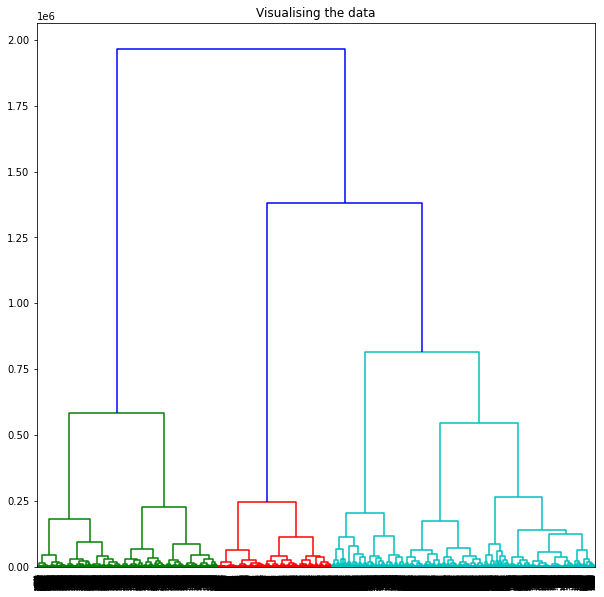

In [14]:
plt.figure(figsize =(10, 10))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(agg1.children_, method ='ward')))

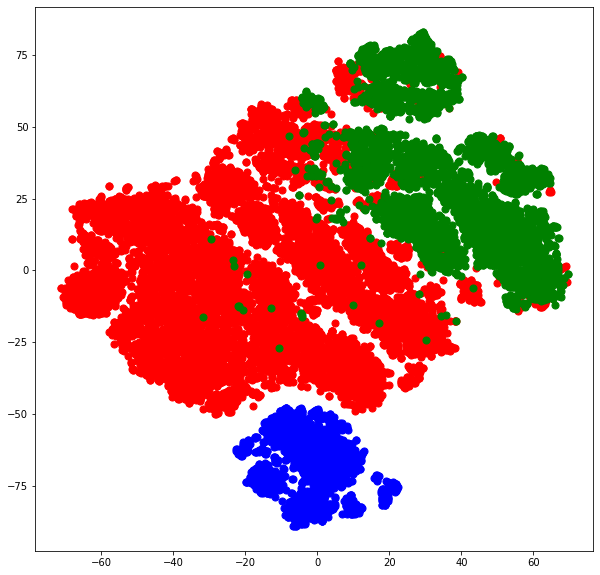

In [22]:
tsneagg=TSNE(n_components=2).fit_transform(X_scaled)
fig=plt.figure(figsize=(10,10))

plt.scatter(tsneagg[labels_agg1==0, 0], tsneagg[labels_agg1==0, 1], s=50, marker='o', color='red')
plt.scatter(tsneagg[labels_agg1==1, 0], tsneagg[labels_agg1==1, 1], s=50, marker='o', color='blue')
plt.scatter(tsneagg[labels_agg1==2, 0], tsneagg[labels_agg1==2, 1], s=50, marker='o', color='green')
plt.show()

##Agglomerative Clustering for 5 Clusters

In [23]:
agg1 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
labels_agg1 = agg1.fit_predict(X_scaled)
counts = collections.Counter(labels_agg1)
print(counts)

score, outliers = silhouette_score(labels_agg1,X_scaled)
print("\nSilhouette Score:",score,"\nNumber of outliers:",len(outliers))
avg_diameter_dist(labels_agg1,X_scaled)
avg_linkage_dist(labels_agg1,X_scaled)
similar_attributes(labels_agg1,X_scaled,df_data_pro.columns)
cluster_diff_by(labels_agg1,X_scaled,df_data_pro.columns)
diff_attrs_outliers(labels_agg1,X_scaled,df_data_pro.columns)

Counter({0: 5703, 1: 5407, 2: 4020, 3: 2025, 4: 992})

Silhouette Score: 0.24551533842718531 
Number of outliers: 6896

Average Complete Diameter (Intracluster) : 56.0

Average Linkage Distance (Intercluster) : 300.0

Top K similar features in cluster  0  :  ['Wage', 'GKDiving', 'International Reputation', 'LS', 'BallControl']
Name of cluster 0  :  ('Wage', 'GKDiving', 'International Reputation')

Top K similar features in cluster  1  :  ['LS', 'GKDiving', 'Wage', 'LWB', 'International Reputation']
Name of cluster 1  :  ('LS', 'GKDiving', 'Wage')

Top K similar features in cluster  2  :  ['GKDiving', 'Jersey Number', 'LWB', 'Wage', 'Real Face']
Name of cluster 2  :  ('GKDiving', 'Jersey Number', 'LWB')

Top K similar features in cluster  3  :  ['Defense Work Rate', 'Attack Work Rate', 'Wage', 'Preferred Foot', 'Value']
Name of cluster 3  :  ('Defense Work Rate', 'Attack Work Rate', 'Wage')

Top K similar features in cluster  4  :  ['GKDiving', 'Release Clause', 'Jersey Number', 'Value'

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


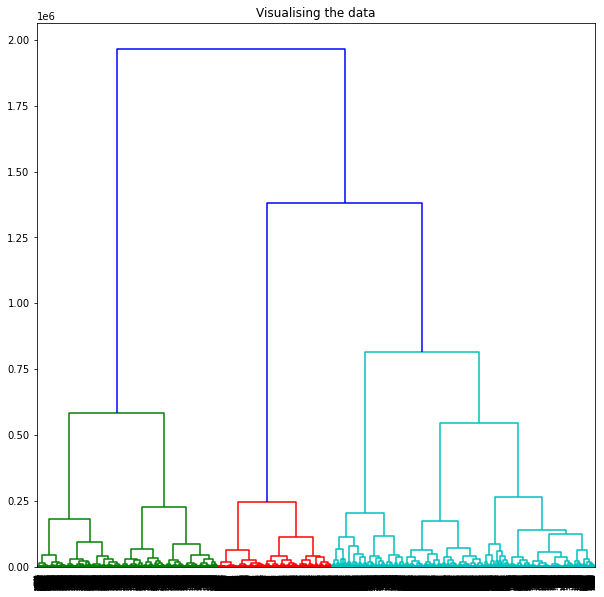

In [24]:
plt.figure(figsize =(10, 10))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(agg1.children_, method ='ward')))

##Agglomerative Clustering for 7 Clusters

In [25]:
agg1 = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
labels_agg1 = agg1.fit_predict(X_scaled)
counts = collections.Counter(labels_agg1)
print(counts)

score, outliers = silhouette_score(labels_agg1,X_scaled)
print("\nSilhouette Score:",score,"\nNumber of outliers:",len(outliers))
avg_diameter_dist(labels_agg1,X_scaled)
avg_linkage_dist(labels_agg1,X_scaled)
similar_attributes(labels_agg1,X_scaled,df_data_pro.columns)
cluster_diff_by(labels_agg1,X_scaled,df_data_pro.columns)
diff_attrs_outliers(labels_agg1,X_scaled,df_data_pro.columns)

Counter({0: 4020, 2: 3931, 5: 2949, 1: 2754, 3: 2025, 6: 1476, 4: 992})

Silhouette Score: 0.35152400235390624 
Number of outliers: 1099

Average Complete Diameter (Intracluster) : 52.0

Average Linkage Distance (Intercluster) : 372.0

Top K similar features in cluster  0  :  ['GKDiving', 'Jersey Number', 'LWB', 'Wage', 'Real Face']
Name of cluster 0  :  ('GKDiving', 'Jersey Number', 'LWB')

Top K similar features in cluster  1  :  ['Wage', 'GKDiving', 'International Reputation', 'Real Face', 'LS']
Name of cluster 1  :  ('Wage', 'GKDiving', 'International Reputation')

Top K similar features in cluster  2  :  ['International Reputation', 'Real Face', 'LS', 'LWB', 'Wage']
Name of cluster 2  :  ('International Reputation', 'Real Face', 'LS')

Top K similar features in cluster  3  :  ['Defense Work Rate', 'Attack Work Rate', 'Wage', 'Preferred Foot', 'Value']
Name of cluster 3  :  ('Defense Work Rate', 'Attack Work Rate', 'Wage')

Top K similar features in cluster  4  :  ['GKDiving', 'Rel

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


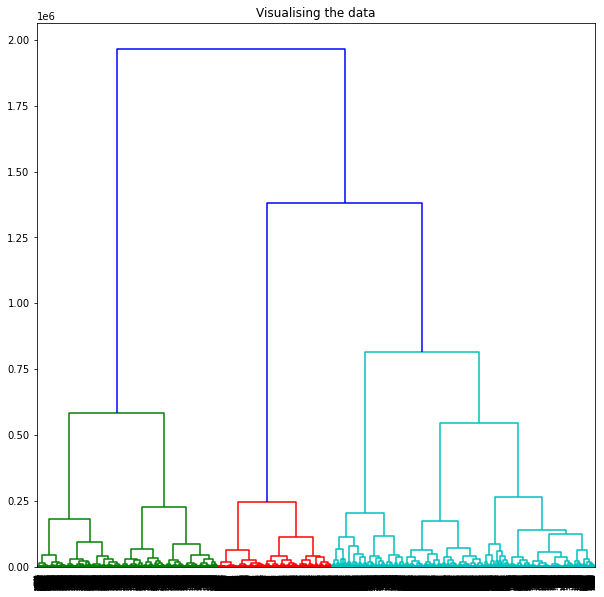

In [26]:
plt.figure(figsize =(10, 10))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(agg1.children_, method ='ward')))

In [28]:
print(agg1.children_.shape)
print(agg1.children_)

(18146, 2)
[[ 1836  1933]
 [15294 15663]
 [17459 17824]
 ...
 [36287 36288]
 [36289 36290]
 [36281 36291]]
